In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit.Chem import MCS
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import rdFMCS
from rdkit import rdBase

from rdkit.Chem import rdMolDescriptors

import numpy as np
import pandas as pd
from rdkit.Chem.Scaffolds.MurckoScaffold import MakeScaffoldGeneric

C:\Users\chris\anaconda3\envs\rdkit\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The rdkit.Chem.MCS module is deprecated; please use rdkit.Chem.rdFMCS instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [2]:
from rdkit.Chem import Draw,rdDepictor
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D
from rdkit.Chem.Scaffolds import rdScaffoldNetwork
import math
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
import pyvis
from pyvis.network import Network
import inspect

print('RDKit version: ',rdBase.rdkitVersion)
print('MatplotLib version:', mpl.__version__)
print('Pyvis version:', pyvis.__version__)


C:\Users\chris\anaconda3\envs\rdkit\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RDKit version:  2020.03.2
MatplotLib version: 3.3.1
Pyvis version: 0.1.8.2


In [3]:
def moltosvg(mol,molSize=(450,250),kekulize=True):
    mc=rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    opts = drawer.drawOptions()
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return svg.replace('svg:','')

C:\Users\chris\anaconda3\envs\rdkit\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
data= pd.read_csv('smiles_list_174.txt')

In [5]:
smiles_list=data['smiles']

In [6]:
mol_list=[]
for smiles in smiles_list:
    mol=Chem.MolFromSmiles(smiles)
    mol_list.append(mol)

## Generic scaffold

In [7]:
sca_list=[]
for smiles in smiles_list:
    tmp=MakeScaffoldGeneric(Chem.MolFromSmiles(smiles))
    sca_list.append(tmp)

In [8]:
len(sca_list)

174

In [9]:
params = rdScaffoldNetwork.ScaffoldNetworkParams()

## try out BRICS bond breaking rules:
#params = rdScaffoldNetwork.BRICSScaffoldParams()

## try out custom bond breaking rules:
#params = rdScaffoldNetwork.ScaffoldNetworkParams(["[$([C;D3]([#0,#6,#7,#8])(=O)):1]-;!@[$([N;!D1;!$(N=*);!$(N-[!#6;!#16;!#0;!#1]);!$([N;R]@[C;R]=O)]):2]>>[1*]-[*:1].[5*]-[*:2]"])

In [10]:
attributes=[a for a in inspect.getmembers(params) if not(a[0].startswith('__'))]
print('params default attributes:')
for a in attributes:
    print('{0}: {1}'.format(a[0],a[1]))


params default attributes:
flattenChirality: True
flattenIsotopes: True
flattenKeepLargest: True
includeGenericBondScaffolds: False
includeGenericScaffolds: True
includeScaffoldsWithAttachments: True
includeScaffoldsWithoutAttachments: True
keepOnlyFirstFragment: True
pruneBeforeFragmenting: True


In [11]:

#params.keepOnlyFirstFragment=False

#팔다리 없는것 제거
params.includeScaffoldsWithAttachments=False

#원자정보 없는것 
params.includeGenericScaffolds=False

#원자정보없고, 단일결합으로 치환된것 
params.includeGenericBondScaffolds=False


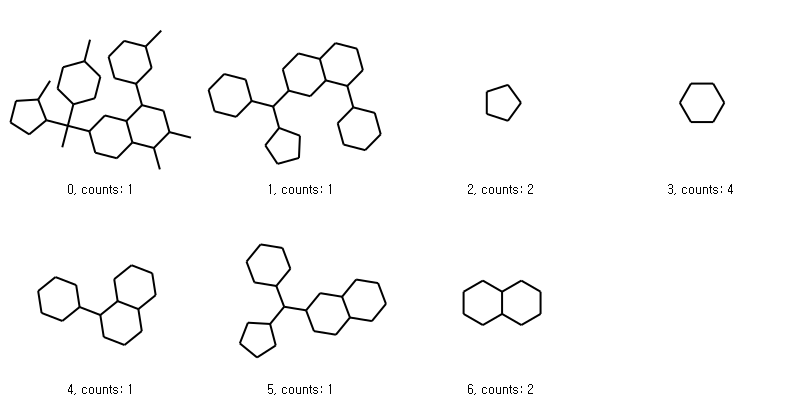

In [12]:
net = rdScaffoldNetwork.CreateScaffoldNetwork([sca_list[0]],params)

nodemols = [Chem.MolFromSmiles(x) for x in net.nodes]
Draw.MolsToGridImage(nodemols,legends=['{0}, counts: {1}'.format(i,c) for i,c in enumerate(net.counts)],molsPerRow=4)


In [13]:
for i in range(len(sca_list)-1):
    rdScaffoldNetwork.UpdateScaffoldNetwork([sca_list[i+1]],net,params)

C:\Users\chris\anaconda3\envs\rdkit\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:188: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  % (maxMols))


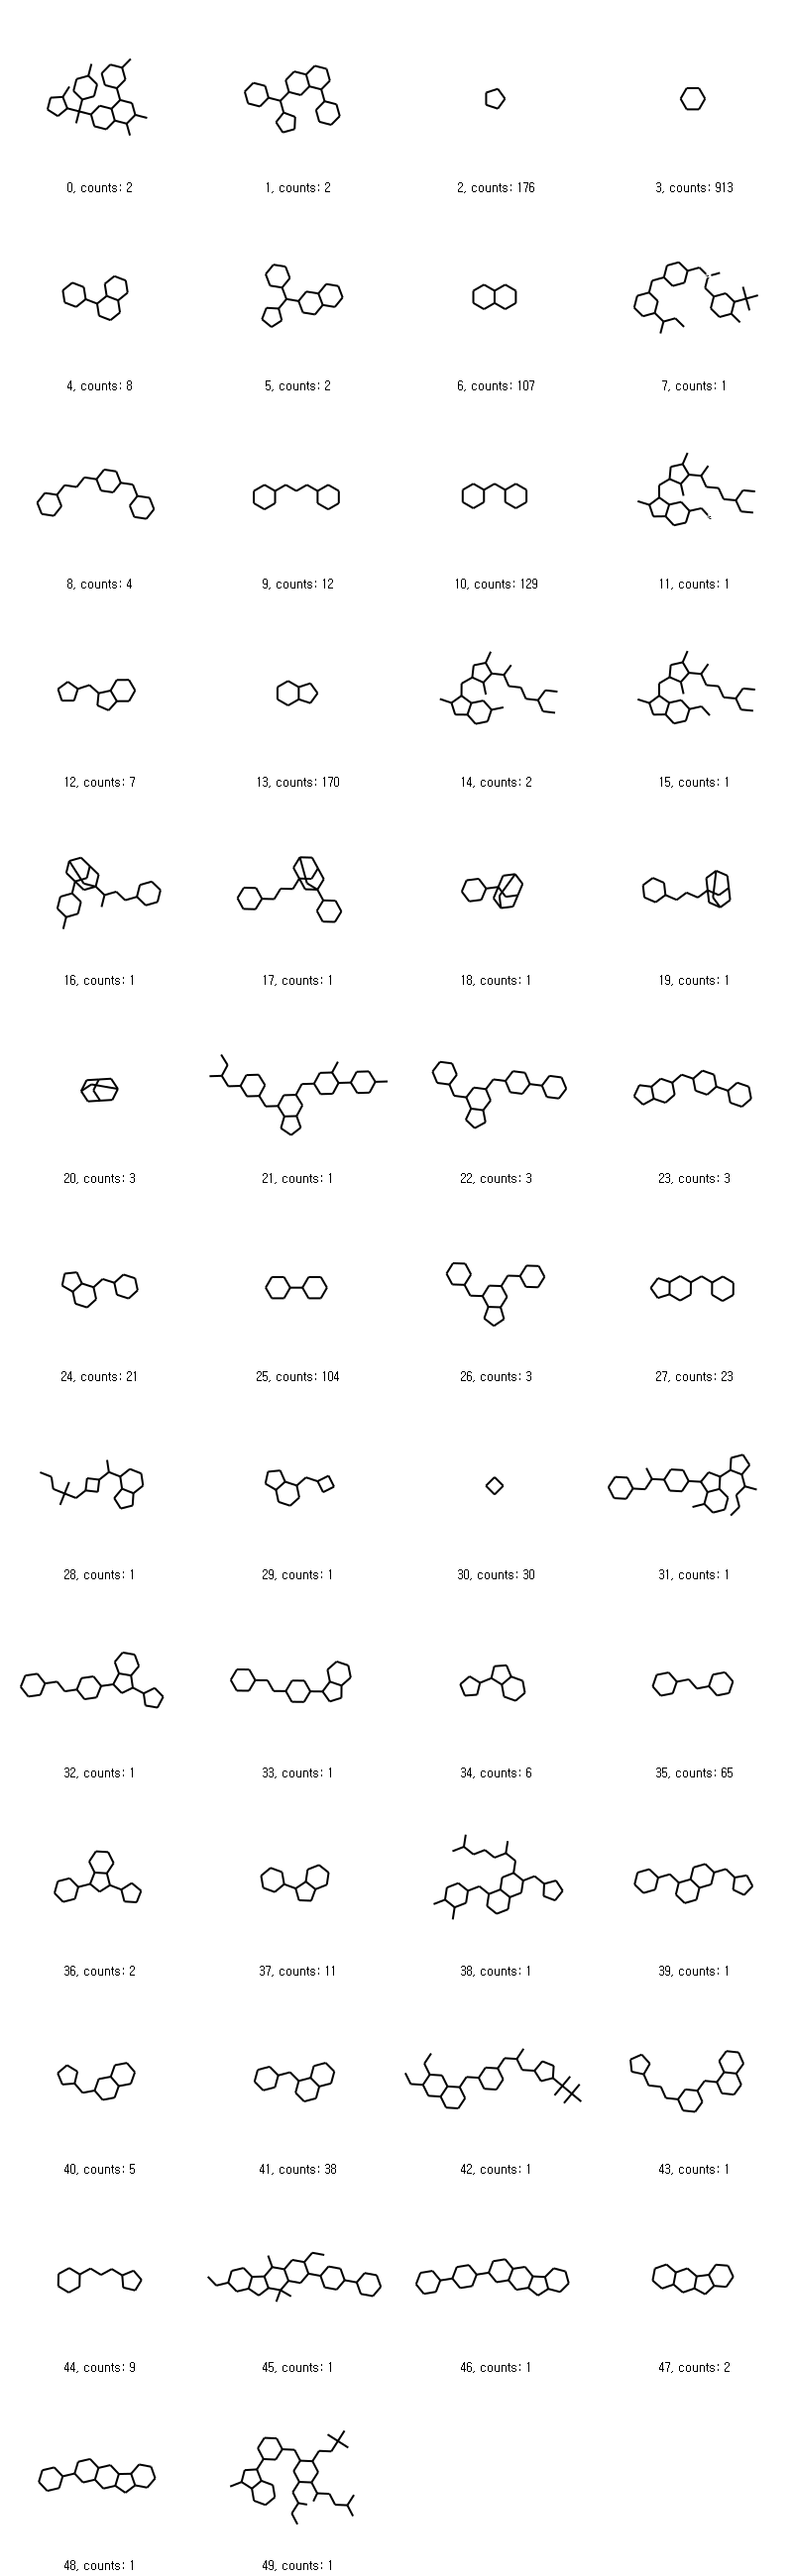

In [14]:


nodemols = [Chem.MolFromSmiles(x) for x in net.nodes]
Draw.MolsToGridImage(nodemols,legends=['{0}, counts: {1}'.format(i,c) for i,c in enumerate(net.counts)],molsPerRow=4,maxMols=50)


if not os.path.isdir('./illu_nib'):
    os.mkdir('./illu_nib')
    
g = Network(notebook=True,height='700px',width='1500px')

for i,n in enumerate(net.nodes):
    svg=moltosvg(Chem.MolFromSmiles(n))
    with open('./illu_nib/{0}.svg'.format(i),'w') as outf:
        outf.write(svg)
    g.add_node(i,shape="image",label=' ',
               image ='./illu_nib/{0}.svg'.format(i), title=svg, size=60)
for e in net.edges:
    g.add_edge(e.beginIdx,e.endIdx,label=str(e.type))
    
g.set_options(options="""{
  "edges": {
   "font":{
   "size":20
   }
  },
  "nodes": {
    "font": {
      "color": "rgba(214,47,66,1)",
      "size": 16,
      "face": "tahoma"
    }
  },
  "physics": {
    "forceAtlas2Based": {
      "gravitationalConstant": -120,
      "springLength": 200,
      "avoidOverlap": 0.42
    },
    "minVelocity": 0.75,
    "solver": "forceAtlas2Based"
  }
}""")
g.show("./scaffoldnetwork_illu_nib.html")

In [15]:
len(nodemols)

562

In [16]:
len(net.counts)

562

In [17]:
freq=[]
for i in range(len(net.counts)):
    freq.append(net.counts[i])

In [18]:
tmp=pd.DataFrame(freq)

In [19]:
tmp.rename(columns={0:'freq'}, inplace = True)

In [20]:
tmp

,freq
0,2
1,2
2,176
3,913
4,8
...,...
557,1
558,1
559,1
560,1


In [21]:
#tmp.to_excel('general scaffold_net_result.xlsx')

C:\Users\chris\anaconda3\envs\rdkit\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [57]:
qq=nodemols[26]

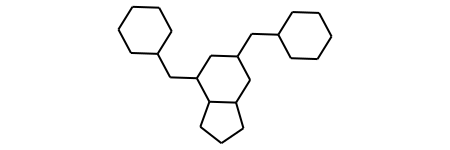

In [58]:
qq

In [59]:
Chem.MolToSmiles(qq)

'C1CCC(CC2CC3CCCC3C(CC3CCCCC3)C2)CC1'

In [60]:
subms3 = [x for x in sca_list if x.HasSubstructMatch(qq)]

In [61]:
len(subms3)

3

In [62]:
img=Draw.MolsToGridImage(subms3,molsPerRow=4)

In [52]:
#img